### Packages for Graphics

In [8]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Preprocessing

### Packages for Data Preprocessing

In [2]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

### Download data from Kaggle

In [3]:
# Define the path to the Kaggle credentials and dataset download directory
kaggle_json_path = '../kaggle.json'
datasets_dir = '../Datasets/'

# Set Kaggle environment to use the credentials from the specific kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(kaggle_json_path)

# Ensure the datasets directory exists
os.makedirs(datasets_dir, exist_ok=True)

# Download the dataset into the 'Datasets' folder
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url, data_dir=datasets_dir)

csv_path = os.path.join(datasets_dir, 'weather-dataset-rattle-package/weatherAUS.csv')
raw_df = pd.read_csv(csv_path)

Skipping, found downloaded files in "../Datasets/weather-dataset-rattle-package" (use force=True to force download)


### Inputs and targets for Training, Validation and Testing datasets

In [4]:
# Drop NaN values from target column
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

def create_inputs_and_targets(df):
    return df[input_cols].copy(), df[target_col].copy()

train_inputs, train_targets = create_inputs_and_targets(train_df)
val_inputs, val_targets = create_inputs_and_targets(val_df)
test_inputs, test_targets = create_inputs_and_targets(test_df)


### Imputing, encoding, Scaling and Encoding

In [5]:
# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()


# Function for transforming inputs (Impute, Scale, One-hot encode)
def preprocess_data(inputs, imputer, scaler, encoder):
    inputs[numeric_cols] = imputer.transform(inputs[numeric_cols])
    inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
    inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
    return inputs[numeric_cols + encoded_cols]


# Impute missing values and scale numeric columns
imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])
scaler = MinMaxScaler().fit(raw_df[numeric_cols])


# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))


# Transform all inputs
train_inputs = preprocess_data(train_inputs, imputer, scaler, encoder)
val_inputs = preprocess_data(val_inputs, imputer, scaler, encoder)
test_inputs = preprocess_data(test_inputs, imputer, scaler, encoder)

/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/1981183413.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/1981183413.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/1981183413.py:10: PerformanceWarning: DataFrame is highly fragmented.  This i

### Save the processed datasets

In [6]:
# Define the directory for processed data
processed_data_dir = './processed_data'
# Ensure the 'processed_data' directory exists
os.makedirs(processed_data_dir, exist_ok=True)

# Save processed data inside 'processed_data' folder
for name, df in zip(['train', 'val', 'test'], [train_inputs, val_inputs, test_inputs]):
    # Save the inputs
    input_path = os.path.join(processed_data_dir, f'{name}_inputs.parquet')
    df.to_parquet(input_path)
    
    # Save the targets
    target_path = os.path.join(processed_data_dir, f'{name}_targets.parquet')
    pd.DataFrame(eval(f'{name}_targets')).to_parquet(target_path)

## Model Training and Evaluation

### Packages for Training and Evaluation Metrics

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import joblib

### Training and Saving the Model

In [9]:
# Select the columns to be used for training/prediction (discarding categorical columns)
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)


# Define the directory for saving the model
saved_model_dir = './model'
# Ensure the 'model' directory exists
os.makedirs(saved_model_dir, exist_ok=True)
# Define the full path to save the model file inside the 'model' folder
model_path = os.path.join(saved_model_dir, 'rain_prediction.joblib')

# Save the trained model
joblib.dump({'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
             'input_cols': input_cols, 'numeric_cols': numeric_cols, 'encoded_cols': encoded_cols}, model_path)



['./model/rain_prediction.joblib']

### Prediction and Evaluation of the Model

#### Plotting impacting coefficients

/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/3279535362.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_bottom_weights, x='weight', y='feature',


<Axes: xlabel='weight', ylabel='feature'>

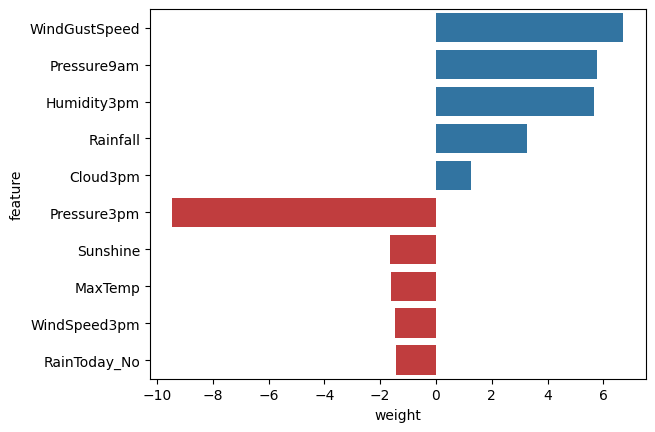

In [14]:
weights_df = pd.DataFrame({
    'feature': numeric_cols + encoded_cols,
    'weight': model.coef_.tolist()[0]
})
weights_df.sort_values('weight', ascending=False)


positive_weights = weights_df[weights_df['weight'] > 0].sort_values('weight', ascending=False).head(5)
negative_weights = weights_df[weights_df['weight'] <= 0].sort_values('weight', ascending=True).head(5)

top_bottom_weights = pd.concat([positive_weights, negative_weights])

# Create a barplot for both positive and negative weights
sns.barplot(data=top_bottom_weights, x='weight', y='feature', 
            palette=['#1f77b4' if x > 0 else '#d62728' for x in top_bottom_weights['weight']])

Training Accuracy: 85.19%


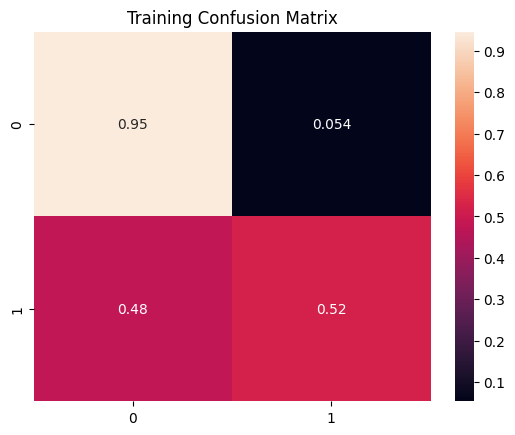

Validation Accuracy: 85.41%


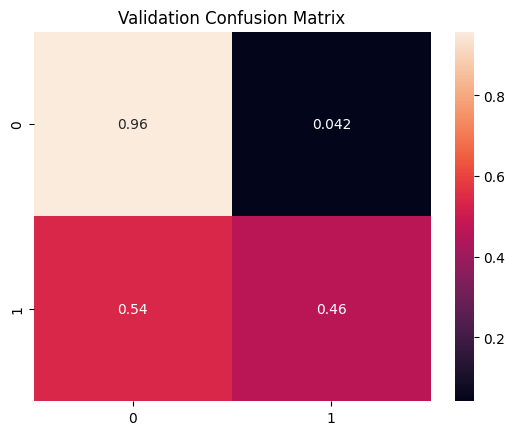

Test Accuracy: 84.25%


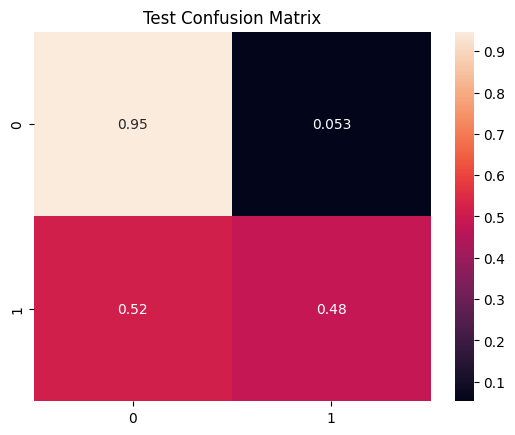

In [15]:
# Generate predictions and probabilities
train_preds = model.predict(X_train)
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

# Helper function to predict and plot
def predict_and_plot(inputs, targets, name):
    preds = model.predict(inputs)
    # print(f"{name} Prob. Distribution: {model.predict_proba(inputs)}")
    accuracy = accuracy_score(targets, preds)
    print(f"{name} Accuracy: {accuracy:.2%}")
    
    cf = confusion_matrix(targets, preds, normalize='true')
    sns.heatmap(cf, annot=True)
    plt.title(f'{name} Confusion Matrix')
    plt.show()

# Evaluate on validation and test set
train_preds = predict_and_plot(X_train, train_targets, 'Training')
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

# model = joblib.load('aussie_rain.joblib')

## Prediction on Single Inputs 

In [13]:
# Function to predict with new input
def predict_input(new_input):
    input_df = pd.DataFrame([new_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(new_input)

/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/284936462.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/284936462.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_96516/284936462.py:6: PerformanceWarning: DataFrame is highly fragmented.  This

('Yes', np.float64(0.6316466668984417))